<a href="https://colab.research.google.com/github/alouwyck/vives-deep-learning/blob/main/topic8/scraping_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

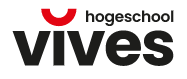<br>


**DEEP LEARNING**<br>
Andy Louwyck

---



---



# **Scraping challenge**

## Opgave

In deze challenge moet je zoveel mogelijk afbeeldingen van Rembrandt-schilderijen 'scrapen' van de volgende site: https://www.rembrandtpainting.net/.

Dat betekent dus dat je Python code moet schrijven die in bulk afbeeldingen downloadt van deze site. Schrijf de gedownloade images weg naar de folder `rembrandt` in de current working directory (cwd). Voer op het einde van de notebook de volgende code uit om te tellen hoeveel images je hebt gedownload:

```python
import os, glob
folder = 'rembrandt'
extension = '*.jpg'
n_images = len(glob.glob(os.path.join(folder, extension)))
print(f'{n_images} images downloaded')
```


**Let op!** Je mag enkel schilderijen (paintings) en zelfportretten (self-portraits) downloaden, geen tekeningen (drawings) of etsen (etchings)!

**Tip:** Je kan hiervoor packages `requests` en `BeautifulSoup` gebruiken: https://en.wikipedia.org/wiki/Beautiful_Soup_(HTML_parser). Of je kan ook eens [Scrapy](https://scrapy.org/) proberen.

## Solution

In [22]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from collections import Counter
import os
from PIL import Image
import shutil
import stat

Ik doorzoek eerst de website op alle mogelijke links. Ik sluit enkele links uit zoals alle links die iets met etchings of drawings te maken hebben. En ook links met een # omdat die steeds verwijzen naar dezelfde pagina maar voor een ander land.

In [23]:
def find_links(url, base_url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    links = set()
    for link in soup.find_all('a'):
        href = link.get('href')
        if href:
            new_link = urljoin(base_url, href)
            if new_link.startswith(base_url) and "etching" not in new_link  and "drawing" not in new_link and not "#" in new_link:
                links.add(new_link)
    return links

In [24]:
def scrape_site(base_url):
    links = find_links(base_url, base_url)
    links_history = {base_url}
    
    while links:
        print(f"Links to visit: {len(links)}")
        link = links.pop()
        links_history.add(link)
        new_links = find_links(link, base_url)
        links.update(new_links - links_history)
    
    return links_history

base_url = "http://www.rembrandtpainting.net/"
all_links = scrape_site(base_url)
len(all_links)

Links to visit: 25
Links to visit: 55
Links to visit: 54
Links to visit: 222
Links to visit: 228
Links to visit: 228
Links to visit: 229
Links to visit: 230
Links to visit: 231
Links to visit: 232
Links to visit: 233
Links to visit: 232
Links to visit: 233
Links to visit: 232
Links to visit: 233
Links to visit: 234
Links to visit: 235
Links to visit: 236
Links to visit: 237
Links to visit: 237
Links to visit: 238
Links to visit: 239
Links to visit: 238
Links to visit: 239
Links to visit: 240
Links to visit: 240
Links to visit: 241
Links to visit: 242
Links to visit: 241
Links to visit: 242
Links to visit: 242
Links to visit: 243
Links to visit: 244
Links to visit: 243
Links to visit: 244
Links to visit: 244
Links to visit: 245
Links to visit: 247
Links to visit: 248
Links to visit: 249
Links to visit: 249
Links to visit: 248
Links to visit: 249
Links to visit: 250
Links to visit: 251
Links to visit: 252
Links to visit: 251
Links to visit: 250
Links to visit: 251
Links to visit: 250
Lin

787

Hierna zoek ik op deze links alle mogelijke afbeeldingen. Ik haal steeds de verwijzing naar de afbeelding uit het img element. Ik sluit de verwijzing naar de amazon website uit en zorg ervoor dat er geen verwijzingen naar etchings of drawings zijn. Ik zorg er ook voor dat het enkel .jpg afbeeldingen zijn.

In [25]:
def is_painting_or_self_portrait(url):
    return ("amazon" not in url 
            and "etching" not in url 
            and "drawing" not in url 
            and url.endswith(".jpg"))

In [26]:
def find_all_image_links(links):
    image_links = set()
    for link in links:
        response = requests.get(link)
        soup = BeautifulSoup(response.text, 'html.parser')
        for img in soup.find_all('img'):
            img_url = urljoin(link, img.get('src'))
            if is_painting_or_self_portrait(img_url): 
                image_links.add(img_url)
    return image_links

image_links = find_all_image_links(all_links)
len(image_links)

553

Na het bekijken van de meest voorkomende woorden zie ik dat 'thmbnl' het meest voorkomt. Dit zijn afbeeldingen van schilderijen in lagere resolutie, die verder op de site in hogere resolutie terug te vinden zijn. Deze haal ik uit de 'image_links' set.

In [27]:
image_names = {link.split('/')[-1] for link in image_links}
len(image_names)

534

In [28]:
words = [name[:-4] for name in image_names]
words = [word.split("_") for word in words]
word_counts = Counter([word for sublist in words for word in sublist])
word_counts.most_common(10)

[('thmbnl', 207),
 ('portrait', 25),
 ('slfprtrt', 24),
 ('and', 18),
 ('prtrt', 15),
 ('woman', 15),
 ('bis', 15),
 ('slf', 14),
 ('slfptrt', 14),
 ('saskia', 13)]

In [29]:
image_links = {link for link in image_links if "thmbnl" not in link}
len(image_links)

341

Ik bekeek ook als er verwijzingen waren naar dezelfde afbeelding. Ik zal deze apart downloaden om te bekijken als dit verwijzingen zijn naar 2 verschillende afbeeldingen met dezelfde naam.

In [30]:
image_names_list = [link.split('/')[-1] for link in image_links]
name_counts = Counter(image_names_list)
duplicates = {name: count for name, count in name_counts.items() if count > 1}
duplicates

{'crucifixion.jpg': 2,
 'stoffels.jpg': 2,
 'entombment.jpg': 2,
 'slfprtrt_as_zeus.jpg': 2,
 'syndics.jpg': 2,
 'artemisia.jpg': 2,
 'gold_helmet.jpg': 2,
 'samaritan.jpg': 2,
 'polish_rider.jpg': 2,
 'prodigal.jpg': 3,
 'helmet.jpg': 2,
 'night_watch.jpg': 3,
 'bathsheba.jpg': 2}

In [31]:
non_duplicate_links = [link for link in image_links if link.split('/')[-1] not in duplicates]
duplicate_links = [link for link in image_links if link.split('/')[-1] in duplicates]
len(non_duplicate_links), len(duplicate_links)

(313, 28)

Hierna download ik de niet duplicate afbeeldingen.

In [32]:
def download_image(link, folder, image_name=None):
    try:
        img_response = requests.get(link)
        image_name = link.split('/')[-1]
        with open(f"{folder}/{image_name}", 'wb') as img_file:
            img_file.write(img_response.content)
    except Exception as e:
        print(f"Error of type {type(e)} downloading {link}: {e}")

In [33]:
folder = "images/rembrandt"
os.makedirs(folder, exist_ok=True)
for link in non_duplicate_links:
    download_image(link, folder)  

Hierna bekijk ik de duplicate afbeeldingen. Deze plaats ik telkens in een folder en hiervan neem ik dan degene met de hoogste resolutie. Hierna verwijder ik de folder.

In [34]:
for link in duplicate_links:
    image = link.split('/')[-1]
    number = duplicates[image]
    duplicates[image] = number - 1
    folder_name = f"images/{image[:-4]}"

    os.makedirs(folder_name, exist_ok=True)

    image_name = f"{folder_name}_{number}.jpg"
    download_image(link, folder_name, image_name)
    

In [35]:
dirs = os.listdir("images")
dirs.remove("rembrandt")
dirs = [f"images/{dir}" for dir in dirs]
dirs

['images/artemisia',
 'images/bathsheba',
 'images/crucifixion',
 'images/entombment',
 'images/gold_helmet',
 'images/helmet',
 'images/night_watch',
 'images/polish_rider',
 'images/prodigal',
 'images/samaritan',
 'images/slfprtrt_as_zeus',
 'images/stoffels',
 'images/syndics']

In [36]:
def get_image_resolution(image_path):
    with Image.open(image_path) as img:
        return img.size

In [37]:
dirs = os.listdir("images")
dirs.remove("rembrandt")
dirs = [f"images/{dir}" for dir in dirs]

for dir in dirs:
    print(f"Processing directory: {dir}")
    files = os.listdir(dir)
    highest_res_file = None
    highest_res = (0, 0) 

    for file in files:
        image_path = os.path.join(dir, file)
        width, height = get_image_resolution(image_path)
        print(f"{file}: {width}x{height}")
        
        if (width * height) > (highest_res[0] * highest_res[1]):
            highest_res = (width, height)
            highest_res_file = file
    
    for file in files:
        if file != highest_res_file:
            image_path = os.path.join(dir, file)
            os.remove(image_path)
            print(f"Deleted: {file}")
    
    print(f"Highest resolution image in {dir}: {highest_res_file} ({highest_res[0]}x{highest_res[1]})")

Processing directory: images/artemisia
artemisia.jpg: 486x450
Highest resolution image in images/artemisia: artemisia.jpg (486x450)
Processing directory: images/bathsheba
bathsheba.jpg: 597x600
Highest resolution image in images/bathsheba: bathsheba.jpg (597x600)
Processing directory: images/crucifixion
crucifixion.jpg: 600x826
Highest resolution image in images/crucifixion: crucifixion.jpg (600x826)
Processing directory: images/entombment
entombment.jpg: 700x555
Highest resolution image in images/entombment: entombment.jpg (700x555)
Processing directory: images/gold_helmet
gold_helmet.jpg: 135x177
Highest resolution image in images/gold_helmet: gold_helmet.jpg (135x177)
Processing directory: images/helmet
helmet.jpg: 450x594
Highest resolution image in images/helmet: helmet.jpg (450x594)
Processing directory: images/night_watch
night_watch.jpg: 170x141
Highest resolution image in images/night_watch: night_watch.jpg (170x141)
Processing directory: images/polish_rider
polish_rider.jpg: 

In [38]:
for dir in dirs:
    file = os.listdir(dir)[0]
    source_path = os.path.join(dir, file)
    destination_path = os.path.join(folder, file)
    destination_path = destination_path[:-6] + ".jpg"
    shutil.move(source_path, destination_path)
    os.rmdir(dir)
    print(f"Moving: {source_path} to {destination_path}")

Moving: images/artemisia/artemisia.jpg to images/rembrandt/artemis.jpg
Moving: images/bathsheba/bathsheba.jpg to images/rembrandt/bathshe.jpg
Moving: images/crucifixion/crucifixion.jpg to images/rembrandt/crucifixi.jpg
Moving: images/entombment/entombment.jpg to images/rembrandt/entombme.jpg
Moving: images/gold_helmet/gold_helmet.jpg to images/rembrandt/gold_helm.jpg
Moving: images/helmet/helmet.jpg to images/rembrandt/helm.jpg
Moving: images/night_watch/night_watch.jpg to images/rembrandt/night_wat.jpg
Moving: images/polish_rider/polish_rider.jpg to images/rembrandt/polish_rid.jpg
Moving: images/prodigal/prodigal.jpg to images/rembrandt/prodig.jpg
Moving: images/samaritan/samaritan.jpg to images/rembrandt/samarit.jpg
Moving: images/slfprtrt_as_zeus/slfprtrt_as_zeus.jpg to images/rembrandt/slfprtrt_as_ze.jpg
Moving: images/stoffels/stoffels.jpg to images/rembrandt/stoffe.jpg
Moving: images/syndics/syndics.jpg to images/rembrandt/syndi.jpg


Hierna verwijder ik de corrupte afbeeldingen en afbeeldingen met een resolutie die lager is dan 100x100. Ik nam deze threshold omdat dit allemaal thumbnails zijn.

In [39]:
folder = "images/rembrandt"
files = os.listdir(folder)
try:
    for file in files:
        image_path = f"{folder}/{file}"
        with Image.open(image_path) as img:
            pass
except Exception as e:
    os.remove(image_path)
    print(f"Removed {image_path} due to error: {e}")


Removed images/rembrandt/0810943174.01._AA240_SCLZZZZZZZ_V53179787_.jpg due to error: cannot identify image file '/mnt/c/Users/timmo/OneDrive - Hogeschool VIVES/Documenten/School 2024-2025/Deep Learning/Schilderijen classificeren/Schilderijen-Classificatie/images/rembrandt/0810943174.01._AA240_SCLZZZZZZZ_V53179787_.jpg'


In [40]:
files = os.listdir(folder)
for file in files:
    image_path = os.path.join(folder, file)
    width, height = get_image_resolution(image_path)
    if width < 100 or height < 100:
        os.chmod(image_path, stat.S_IWRITE)
        os.remove(image_path)
        print(f"Removed: {file}")

Removed: ad_signature.jpg
Removed: artcomposter.jpg
Removed: artcomposter_c.jpg
Removed: bathsheba_thmb.jpg
Removed: blankertrembrandt.jpg
Removed: chkmrktrans.jpg
Removed: civilis.jpg
Removed: connoisseurship.jpg
Removed: dvdrembrandtsmall.jpg
Removed: eching_schwartz.jpg
Removed: femalenudeshdw.jpg
Removed: first_impressions.jpg
Removed: gary.jpg
Removed: genius.jpg
Removed: hyacinthfront.jpg
Removed: mill_thmb.jpg
Removed: nightwatch.jpg
Removed: pronouncedd.jpg
Removed: rembrandtbook.jpg
Removed: rembrandtbook_wetering.jpg
Removed: rembrandt_wetering.jpg
Removed: shadowwomen.jpg
Removed: shdw_lndscp.jpg
Removed: shdw_prtrt.jpg
Removed: shdw_return.jpg
Removed: shdw_sagwe.jpg
Removed: shdw_slfprtrt.jpg
Removed: shdw_studio.jpg
Removed: signblue.jpg
Removed: thmbn_slfptrt_1630.jpg
Removed: thmbn_slfptrt_c.1641.jpg


Hierna verwijder ik manueel afbeelding die geen schilderijen zijn, maar vaak op dezelfde pagina als de schilderijen te vinden zijn. Aangezien de website geen gebruik maakt van extra tags kon ik dit niet automatisch doen.

In [41]:
os.remove(f"{folder}/alpers-rem.jpg")
os.remove(f"{folder}/andsons.jpg")
os.remove(f"{folder}/at-work.jpg")
os.remove(f"{folder}/bankrem.jpg")
os.remove(f"{folder}/bikker.jpg")
os.remove(f"{folder}/catrem.jpg")
os.remove(f"{folder}/document_bis.jpg")
os.remove(f"{folder}/drawn.jpg")
os.remove(f"{folder}/durham.jpg")
os.remove(f"{folder}/dickey.jpg")
os.remove(f"{folder}/eyes.jpg")
os.remove(f"{folder}/fancy.jpg")
os.remove(f"{folder}/ford.jpg")
os.remove(f"{folder}/framed.jpg")
os.remove(f"{folder}/ganz.jpg")
os.remove(f"{folder}/himself.jpg")
os.remove(f"{folder}/landscapes.jpg")
os.remove(f"{folder}/map.jpg")
os.remove(f"{folder}/naked.jpg")
os.remove(f"{folder}/nose.jpg")
os.remove(f"{folder}/rembrandt-book.jpg")
os.remove(f"{folder}/rembrandtmaurits.jpg")
os.remove(f"{folder}/rembrandt's_house.jpg")
os.remove(f"{folder}/rembrandthuis_today.jpg")
os.remove(f"{folder}/rembrandthuis_drwng.jpg")
os.remove(f"{folder}/remcar.jpg")
os.remove(f"{folder}/remremre.jpg")
os.remove(f"{folder}/remvarious.jpg")
os.remove(f"{folder}/revelaed.jpg")
os.remove(f"{folder}/stealing.jpg")
os.remove(f"{folder}/tico.jpg")
os.remove(f"{folder}/treaseures.jpg")
os.remove(f"{folder}/weller.jpg")
os.remove(f"{folder}/women.jpg")

In [42]:
import os, glob
folder = 'images/Rembrandt'
extension = '*.jpg'
n_images = len(glob.glob(os.path.join(folder, extension)))
print(f'{n_images} images downloaded')

260 images downloaded
